In [2]:
# Block 1: Imports, Config, and Helpers
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import trange # For progress bar: pip install tqdm

# --- File Paths ---
frame1_path = r"..\000002_10.png"
frame2_path = r"..\000002_11.png"

# --- Algorithm Config ---
BLOCK_SIZE = 16
SEARCH_RANGE = 32 # Search +/- 32 pixels from the original block position

# --- Output Config ---
output_dir_q2 = Path("./outputs_q2")
output_dir_q2.mkdir(parents=True, exist_ok=True)

# --- Helper Functions ---
def imshow(ax, img, title="", cmap=None):
    """Helper function to display images with matplotlib."""
    ax.imshow(img if cmap is None else img, cmap=cmap)
    ax.set_title(title); ax.axis("off")

def sad(block1, block2):
    """Computes the Sum of Absolute Differences between two blocks."""
    # Use float to prevent overflow during subtraction
    return np.sum(np.abs(block1.astype(np.float32) - block2.astype(np.float32)))

Frames loaded. Original: 375x1242, Cropped to: 368x1232


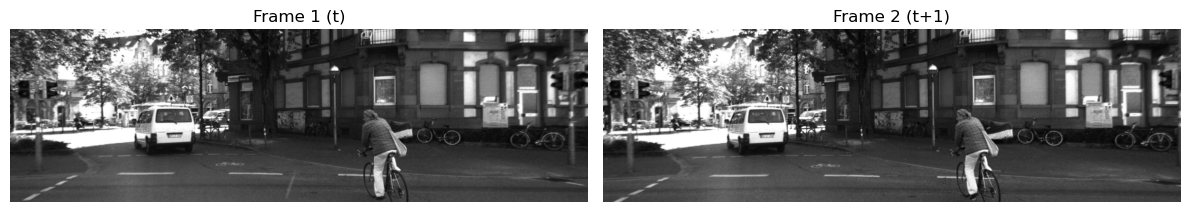

In [3]:
# Block 2: Load Frames and Pre-process
frame1_c = cv2.imread(frame1_path, cv2.IMREAD_GRAYSCALE)
frame2_c = cv2.imread(frame2_path, cv2.IMREAD_GRAYSCALE)

if frame1_c is None or frame2_c is None:
    print(f"Error: Could not load images. Check paths.")
else:
    # --- Ensure dimensions are divisible by BLOCK_SIZE ---
    # This simplifies the code by avoiding partial blocks at the edges.
    H_orig, W_orig = frame1_c.shape
    H = (H_orig // BLOCK_SIZE) * BLOCK_SIZE
    W = (W_orig // BLOCK_SIZE) * BLOCK_SIZE
    
    frame1 = frame1_c[0:H, 0:W]
    frame2 = frame2_c[0:H, 0:W]
    
    print(f"Frames loaded. Original: {H_orig}x{W_orig}, Cropped to: {H}x{W}")

    # Display the loaded images
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    imshow(axs[0], frame1, "Frame 1 (t)", cmap="gray")
    imshow(axs[1], frame2, "Frame 2 (t+1)", cmap="gray")
    plt.tight_layout()
    plt.show()

In [4]:
# Block 3: Block Matching Algorithm (SAD)

# Get the number of blocks in each direction
rows = H // BLOCK_SIZE
cols = W // BLOCK_SIZE

# Create an empty flow field to store motion vectors (dx, dy)
# We store one vector per *block*, not per pixel.
block_flow = np.zeros((rows, cols, 2), dtype=np.int16)

print(f"Starting block matching ({rows}x{cols} blocks)...")

# Use trange for a progress bar
for r in trange(rows, desc="Processing Rows"):
    for c in range(cols):
        # 1. Get current block coordinates
        y1 = r * BLOCK_SIZE
        x1 = c * BLOCK_SIZE
        y2 = y1 + BLOCK_SIZE
        x2 = x1 + BLOCK_SIZE
        
        # 2. Extract the template block from frame 1
        template = frame1[y1:y2, x1:x2]
        
        # 3. Define the search window in frame 2
        # Center the search window at the block's original position
        sy1 = max(0, y1 - SEARCH_RANGE)
        sx1 = max(0, x1 - SEARCH_RANGE)
        sy2 = min(H, y2 + SEARCH_RANGE) # y2 is y1+BLOCK_SIZE
        sx2 = min(W, x2 + SEARCH_RANGE) # x2 is x1+BLOCK_SIZE

        min_sad = np.inf
        best_dx = 0
        best_dy = 0

        # 4. Iterate over the search window
        # We stop iterating when the *start* of the candidate block
        # (y_s, x_s) would make the *end* of the block go past the
        # edge of the search window.
        for y_s in range(sy1, sy2 - BLOCK_SIZE + 1):
            for x_s in range(sx1, sx2 - BLOCK_SIZE + 1):
                # Extract the candidate block from frame 2
                candidate = frame2[y_s:y_s+BLOCK_SIZE, x_s:x_s+BLOCK_SIZE]
                
                # 5. Compute SAD
                current_sad = sad(template, candidate)
                
                # 6. Keep track of the best match
                if current_sad < min_sad:
                    min_sad = current_sad
                    best_dy = y_s - y1 # Motion in y
                    best_dx = x_s - x1 # Motion in x
        
        # 7. Store the best motion vector for this block
        block_flow[r, c] = [best_dx, best_dy]

print("Block matching complete.")

Starting block matching (23x77 blocks)...


Processing Rows: 100%|██████████| 23/23 [01:08<00:00,  2.96s/it]

Block matching complete.


Saved arrow visualization to D:\git\Image and Video Processing\Lab_4\QUESTION2\outputs_q2


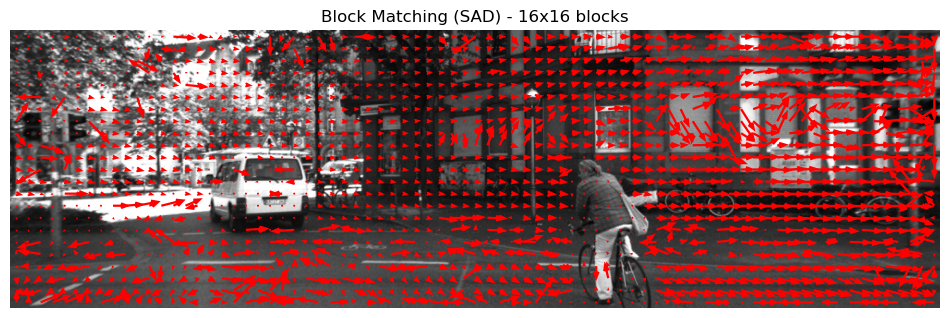

In [5]:
# Block 4: Visualize Motion Vectors as Arrows (Quiver Plot)

# We have one vector per block. We need to create the (x, y)
# coordinates for the *center* of each block to draw the arrows.

# Create grid coordinates for block centers
x_coords = np.arange(BLOCK_SIZE // 2, W, BLOCK_SIZE)
y_coords = np.arange(BLOCK_SIZE // 2, H, BLOCK_SIZE)
X, Y = np.meshgrid(x_coords, y_coords)

# Get the flow vectors (u, v) for this grid
U = block_flow[..., 0] # dx
V = block_flow[..., 1] # dy

# --- Create the Quiver (Arrow) Plot ---
fig, ax = plt.subplots(figsize=(12, 8))

# 1. Display the first frame as the background
ax.imshow(frame1, cmap='gray')

# 2. Overlay the arrows
ax.quiver(X, Y, U, V,
          color='red',
          angles='xy',       # Arrow direction given by (U,V)
          scale_units='xy',  # U,V are in data-coords
          scale=1,           # 1 unit of U = 1 pixel
          headwidth=3,
          headlength=4)

ax.set_title(f"Block Matching (SAD) - {BLOCK_SIZE}x{BLOCK_SIZE} blocks")
ax.axis('off')

# Save and show the figure
fig.savefig(output_dir_q2 / "q2_block_matching_arrows.png", bbox_inches='tight')
print(f"Saved arrow visualization to {output_dir_q2.resolve()}")
plt.show()

Saved magnitude visualization to D:\git\Image and Video Processing\Lab_4\QUESTION2\outputs_q2


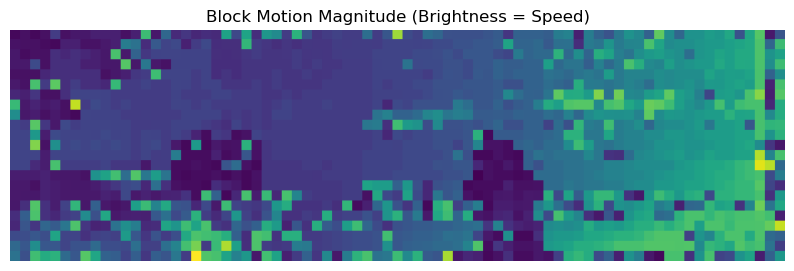

In [6]:
# Block 5: Visualize Flow Magnitude (Optional but helpful)

# Calculate the magnitude (speed) of each block's motion
magnitude = np.sqrt(U**2 + V**2)

# Normalize to 0-255 for visualization
mag_norm = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)

# We need to "upscale" the blocky magnitude map to the full image size
# to see it clearly. We can use cv2.resize with nearest neighbor interpolation.
mag_image = cv2.resize(mag_norm, (W, H), interpolation=cv2.INTER_NEAREST)

fig, ax = plt.subplots(figsize=(10, 8))
imshow(ax, mag_image, f"Block Motion Magnitude (Brightness = Speed)", cmap="viridis")
fig.savefig(output_dir_q2 / "q2_block_matching_magnitude.png", bbox_inches='tight')
print(f"Saved magnitude visualization to {output_dir_q2.resolve()}")
plt.show()

In [ ]:
# Block 6: Analysis Comments
print("\n--- Block 6: Analysis ---")
print("Q: Comment on: a) Which regions exhibit larger motion vectors and why?")
print("   A: The regions with larger motion vectors (longer arrows, brighter in magnitude plot) are")
print("      objects in the foreground (e.g., street signs, guard rails). This is due to 'motion parallax':")
print("      as the camera moves forward, closer objects appear to move faster across the image frame")
print("      than distant objects.")
print("\nQ: b) How stationary regions appear in terms of motion vectors?")
print("   A: Stationary regions (like the distant sky, far-away buildings, or the road far ahead) have")
print("      motion vectors that are zero or near-zero. They appear as small dots in the arrow plot")
print("      and as dark (blue/black) areas in the magnitude plot.")
print("\nQ: c) How the choice of block size affects the accuracy of motion estimation?")
print("   A: - Smaller Blocks (e.g., 8x8): Good at capturing fine-grained motion and locating small objects.")
print("      But, they fail in textureless regions (like the sky or road) due to ambiguity (the 'aperture problem').")
print("   A: - Larger Blocks (e.g., 32x32): More robust to noise and work well for large, textured surfaces.")
print("      But, they provide poor localization. If a block covers both a foreground object and the")
print("      background, it computes one incorrect 'average' motion for the whole block, blurring motion boundaries.")
print("   A: - Conclusion: The 16x16 size is a common compromise between robustness and localization accuracy.")